In [1]:
import pandas as pd
import pytorch_lightning as pl
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import as_tensor
import tarfile
from glob import glob
from pathlib import Path

In [71]:
# Expects a path to a tar file containing a folder (with images) of the same name as the tar
# path_to_images = './data/saatchi512.tar'
# image_extraction_path = './data/images/'
# path_to_target_data = r'C:\Users\R\PycharmProjects\Thesis_cur-AI-tor\notebooks\data/saatchi_targets.csv'
# path_to_resnet_features = '.data/saatchi_all_resnet_features.bz2'


# Expects a path to a tar file containing a folder (with images) of the same name as the tar
path_to_images = r'F:\temp\thesisdata\automobile.tar'
image_extraction_path = r'F:\temp\thesisdata\datamodule_testing'
path_to_target_data = r'C:\Users\R\PycharmProjects\Thesis_cur-AI-tor\notebooks\data/saatchi_targets.csv'
path_to_resnet_features = r'F:\temp\thesisdata\saatchi_all_resnet_features.bz2'

# Load target data
targets_df = pd.read_csv(path_to_target_data, header=None)
targets_df.columns = ['FILENAME', 'PRICE', 'LIKES_VIEWS_RATIO']
# Bin the values
targets_df['PRICE_BIN_IDX'] = pd.qcut(targets_df['PRICE'], q=5, labels=[0, 1, 2, 3, 4])
targets_df['LIKES_VIEWS_RATIO_BIN_IDX'] = pd.qcut(targets_df['LIKES_VIEWS_RATIO'], q=5, labels=[0, 1, 2, 3, 4])
targets_df = targets_df.astype({'PRICE_BIN_IDX': int, 'LIKES_VIEWS_RATIO_BIN_IDX': int})
targets_df.drop(['PRICE', 'LIKES_VIEWS_RATIO'], axis=1, inplace=True)
targets_df.set_index('FILENAME', inplace=True)

In [72]:
class SaatchiDataset(Dataset):
    # training_set = df[:88000]
    # validation_set = df[88000:93000]
    # test_set = df[93000:]
    targets_df = pd.read_csv(path_to_target_data, header=None)
    targets_df.columns = ['FILENAME', 'PRICE_BIN_IDX', 'LIKES_VIEWS_RATIO_BIN_IDX']
    targets_df.set_index('FILENAME', inplace=True)

    training_set = pd.DataFrame([1,2,3])
    validation_set = pd.DataFrame([1,2,3])
    test_set = pd.DataFrame([1,2,3])

    @property
    def targets(self):
        return self.targets_

    @property
    def data(self):
        return self.data_

    def untar_images(self, path):
        self.dataset_tarfile = tarfile.open(path)
        self.dataset_tarfile.extractall(image_extraction_path)
        self.dataset_tarfile.close()
        print(image_extraction_path + '/*/*')
        return glob(image_extraction_path + '/*/*')

    def __init__(self,
                 stage: str = 'train',
                 target_selection: str = 'likes_view_ratio',
                 source_selection: str = 'resnet18+engineered_features'):
        self.dataset_tarfile = None
        self.filelist = None
        self.split_fractions = {
            'train': 0.8,
            'validation': 0.1,
            'test': 0.1,
        }

        # Validate arguments
        if stage not in ['train', 'validation', 'test']:
            print(f'Invalid stage specified: "{stage}" , valid options are: [train, validation, test].')
        else:
            self.stage = stage

        if target_selection not in ['price', 'likes_view_ratio']:
            print(
                f'Invalid target selection specified: "{target_selection}"'
                f', valid options are: [price, likes_view_ratio].')
        else:
            self.target_selection = target_selection

        if source_selection not in ['images', 'resnet_features', 'engineered_features', 'resnet18+engineered_features']:
            print(
                f'Invalid source selection specified: "{source_selection}"'
                f', valid options are: [images, resnet_features, engineered_features, resnet18+engineered_features].')
        else:
            self.source_selection = source_selection

        # Define transforms for images
        self.transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])



        # Create dataset
        if source_selection == 'images':
            self.filelist = self.untar_images(path_to_images)
            # Calculate how many images belong in train, validation, and test
            self.train_fraction = int(len(self.filelist) * self.split_fractions['train'])
            self.validation_fraction = int(len(self.filelist) * self.split_fractions['validation'])
            self.test_fraction = int(len(self.filelist) * self.split_fractions['test'])

            if self.stage == 'train':
                self.data_ = self.filelist[:self.train_fraction]
            elif self.stage == 'validation':
                self.data_ = self.filelist[self.train_fraction:self.train_fraction + self.validation_fraction]
            elif self.stage == 'test':
                self.data_ = self.filelist[self.train_fraction + self.validation_fraction:]

        elif source_selection == 'resnet_features':
            self.resnet_features_df = pd.read_json(path_to_resnet_features)
            self.features_and_targets_df = df_engineered.join(self.resnet_features_df, how='inner')
            if self.stage == 'train':
                self.dataset = self.training_set
            elif self.stage == 'validation':
                self.dataset = self.validation_set
            elif self.stage == 'test':
                self.dataset = self.test_set

            self.data_ = self.dataset.drop(['PRICE_BIN_IDX', 'LIKES_VIEWS_RATIO_BIN_IDX'], axis=1).values

            if self.target_selection == 'price':
                self.targets_ = self.dataset['PRICE_BIN_IDX'].values
            elif self.target_selection == 'likes_view_ratio':
                self.targets_ = self.dataset['LIKES_VIEWS_RATIO_BIN_IDX'].values


    def __getitem__(self, index):
        print(self.target_selection)
        if self.source_selection == 'images':
            img = Image.open(self.data_[index])
            image_tensor = self.transform(img)
            return image_tensor
        else:
            return as_tensor(self.data_[index]).float(), as_tensor(self.targets_[index]).long()

    def __len__(self):
        return len(self.data_)

In [75]:
d = SaatchiDataset(stage='validation',
                 target_selection='likes_view_ratio',
                 source_selection='images')

F:\temp\thesisdata\datamodule_testing/*/*


In [77]:
d.__getitem__(3)

likes_view_ratio


IndexError: list index out of range

In [43]:
d.__len__()

17

In [32]:
d.filelist

['F:\\temp\\thesisdata\\datamodule_testing\\automobile\\2107367_2107367_691250_1213667-PXKEADEQ-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\2177183_2177183_700236_1255952-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\2290086_2290086_716968_1365225-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\2601707_2601707_777804_1671600-RFLSRIBT-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\2910586_2910586_675147_1980479-ZGJAPHSR-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\3485222_3485222_911283_2555109-ACWKFBPG-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\4024731_4024731_69488_3094585-CEFQZEEE-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\4069188_4069188_285048_3139041-UIOYPVVF-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\4816805_4816805_1093477_3886633-GQNKKIBI-7.jpg',
 'F:\\temp\\thesisdata\\datamodule_testing\\automobile\\5324669_5324669_1099988_43

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


likes_view_ratio


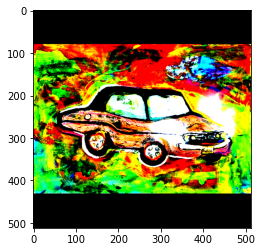

In [45]:
import matplotlib.pyplot as plt
plt.imshow(d.__getitem__(8).permute(1, 2, 0)  )

In [44]:
d = SaatchiDataset(stage:='train',
                 target_selection='likes_view_ratio',
                 source_selection='engineered_features')

KeyError: "['PRICE_BIN_IDX' 'LIKES_VIEWS_RATIO_BIN_IDX'] not found in axis"

FileNotFoundError: [Errno 2] No such file or directory: './data/saatchi_targets.csv'

In [70]:
ddf = pd.read_json(path_to_resnet_features)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
ddf.head()

In [78]:

# Load target data
targets_df = pd.read_csv(path_to_target_data, header=None)
targets_df.columns = ['FILENAME', 'PRICE', 'LIKES_VIEWS_RATIO']
# Bin the values
targets_df['PRICE_BIN_IDX'] = pd.qcut(targets_df['PRICE'], q=5, labels=[0, 1, 2, 3, 4])
targets_df['LIKES_VIEWS_RATIO_BIN_IDX'] = pd.qcut(targets_df['LIKES_VIEWS_RATIO'],
                                                       q=5, labels=[0, 1, 2, 3, 4])
targets_df = targets_df.astype({'PRICE_BIN_IDX': int, 'LIKES_VIEWS_RATIO_BIN_IDX': int})
targets_df.drop(['PRICE', 'LIKES_VIEWS_RATIO'], axis=1, inplace=True)
targets_df.set_index('FILENAME', inplace=True)
targets_df.head()

,PRICE_BIN_IDX,LIKES_VIEWS_RATIO_BIN_IDX
FILENAME,,
6820473_6820473_19085_5890111-GDDFGNME-7.jpg,4,4
3418279_3418279_925751_2488166-UWHWWQQI-7.jpg,2,1
3419767_3419767_297066_2489654-YPOIIREG-7.jpg,3,0
3423848_3423848_790896_2493735-FAPOEHRA-7.jpg,3,1
3424674_3424674_925431_2494561-SSSTLNTC-7.jpg,3,1


In [80]:
targets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621002 entries, 6820473_6820473_19085_5890111-GDDFGNME-7.jpg to 3418165_3418165_662192_2488052-ZHNOIHXF-7.jpg
Data columns (total 2 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   PRICE_BIN_IDX              621002 non-null  int32
 1   LIKES_VIEWS_RATIO_BIN_IDX  621002 non-null  int32
dtypes: int32(2)
memory usage: 9.5+ MB


In [84]:
targets_df.loc['2680311_2680311_517587_1750204-RZUHWIMA-7.jpg']


PRICE_BIN_IDX                1
LIKES_VIEWS_RATIO_BIN_IDX    0
Name: 2680311_2680311_517587_1750204-RZUHWIMA-7.jpg, dtype: int32

In [86]:
targets_df.loc['3579441_3579441_839027_2649327-JNBUMTOM-7.jpg']

PRICE_BIN_IDX                0
LIKES_VIEWS_RATIO_BIN_IDX    2
Name: 3579441_3579441_839027_2649327-JNBUMTOM-7.jpg, dtype: int32

In [95]:
x = pd.DataFrame(targets_df.reset_index().drop_duplicates(subset=['FILENAME'])).set_index('FILENAME')
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619862 entries, 6820473_6820473_19085_5890111-GDDFGNME-7.jpg to 3418165_3418165_662192_2488052-ZHNOIHXF-7.jpg
Data columns (total 2 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   PRICE_BIN_IDX              619862 non-null  int32
 1   LIKES_VIEWS_RATIO_BIN_IDX  619862 non-null  int32
dtypes: int32(2)
memory usage: 9.5+ MB


In [96]:
x.head()

,PRICE_BIN_IDX,LIKES_VIEWS_RATIO_BIN_IDX
FILENAME,,
6820473_6820473_19085_5890111-GDDFGNME-7.jpg,4,4
3418279_3418279_925751_2488166-UWHWWQQI-7.jpg,2,1
3419767_3419767_297066_2489654-YPOIIREG-7.jpg,3,0
3423848_3423848_790896_2493735-FAPOEHRA-7.jpg,3,1
3424674_3424674_925431_2494561-SSSTLNTC-7.jpg,3,1


In [97]:
img = Image.open(r'C:\Users\R\PycharmProjects\Thesis_Saatchi_scraper\micro_dataset1\8340916_8340916_1709330_7405683-GFSEHQIK-7.jpg')

In [99]:
dir(img)

['_Image__transformer',
 '__array_interface__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_category',
 '_close_exclusive_fp_after_loading',
 '_copy',
 '_crop',
 '_dump',
 '_ensure_mutable',
 '_exclusive_fp',
 '_exif',
 '_expand',
 '_get_safe_box',
 '_getexif',
 '_getmp',
 '_min_frame',
 '_new',
 '_open',
 '_repr_png_',
 '_seek_check',
 '_size',
 '_xmp',
 'alpha_composite',
 'app',
 'applist',
 'bits',
 'close',
 'convert',
 'copy',
 'crop',
 'custom_mimetype',
 'decoderconfig',
 'decodermaxblock',
 'draft',
 'effect_spread',
 'entropy',
 'filename',
 'filter',
 'format',
 '

In [100]:
img.size


(770, 1721)